In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString
from shapely import wkt
import json
%matplotlib inline

Loading our data:

In [2]:
# Loading csv straight into geopandas seems to be funky
# So I'll load into pandas first and apply shapely wkt.loads function first
data = pd.read_csv("../data/gis_data.csv")
data['geometry'] = data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(data)

<Axes: >

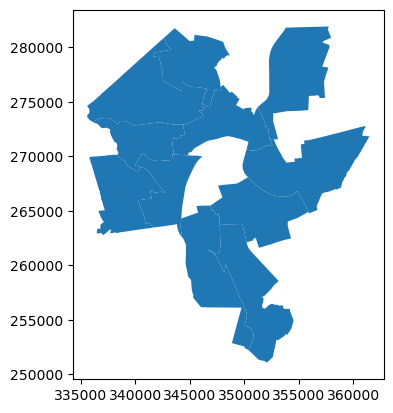

In [3]:
gdf.plot()

<Axes: >

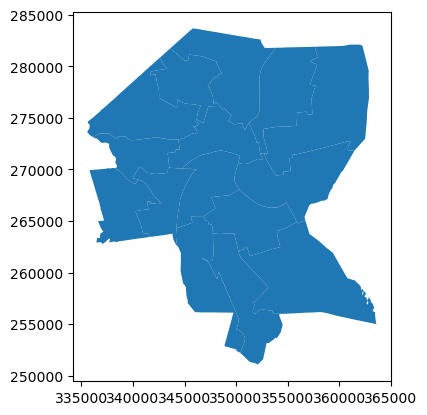

In [4]:
gdf_pvd = gpd.read_file("../data/BND_PVD_Wards_2022.shp")
gdf_pvd.plot()

In [5]:
np.unique(gdf['DISTRICT'])

array([ 1,  3,  5,  6,  7,  8,  9, 11, 12, 14, 15], dtype=int64)

We're missing information on Wards 2, 4, and 13 in our data, which reflects in the plot. Maybe we can add them back in but with NA values?

In [7]:
districts = [2,4,13]
for district in districts:
    gdf = pd.concat([gdf, gdf_pvd.iloc[[district-1]]])

c:\Users\DWang\anaconda3\envs\evc\Lib\site-packages\geopandas\array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NAD83(2011) / Rhode Island (ftUS) (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [8]:
gdf.set_index("ID").sort_index()

,DISTRICT,DISTRICTN,Shape_STAr,Shape_STLe,geometry,Q1,Q2_18-24,Q2_25-29,Q2_30-39,Q2_40-49,...,Q19_Definitely,Q19_Definitely Not,Q19_I would need more information to make a decision,Q19_Probably,Q19_Probably Not,Q20_Definitely,Q20_Definitely Not,Q20_I would need more information to make a decision,Q20_Probably,Q20_Probably Not
ID,,,,,,,,,,,,,,,,,,,,,
1,1,1.0,4.626871e+07,37132.487547,"POLYGON ((353880.285 269409.163, 354275.176 26...",1.0,15.0,24.0,15.0,7.0,...,63.0,2.0,4.0,7.0,2.0,31.0,6.0,14.0,15.0,12.0
2,2,2.0,6.857744e+07,45920.952108,"POLYGON ((353740.517 269601.048, 353659.443 26...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,3.952432e+07,33051.393756,"POLYGON ((352200.695 272587.857, 352185.706 27...",3.0,7.0,11.0,21.0,11.0,...,49.0,3.0,3.0,9.0,4.0,18.0,6.0,13.0,24.0,7.0
4,4,4.0,4.590033e+07,37093.253292,"POLYGON ((350897.885 273804.377, 350888.071 27...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5.0,4.342423e+07,37105.452695,"POLYGON ((341271.842 272989.464, 341151.392 27...",5.0,5.0,4.0,29.0,14.0,...,46.0,9.0,7.0,11.0,6.0,25.0,4.0,17.0,20.0,13.0
6,6,6.0,2.091428e+07,25538.226701,"POLYGON ((341072.364 272964.21, 341151.392 272...",6.0,7.0,13.0,16.0,11.0,...,34.0,10.0,6.0,11.0,4.0,17.0,8.0,13.0,17.0,11.0
7,7,7.0,2.983633e+07,30271.723284,"POLYGON ((335779.467 269938.082, 335904.304 26...",7.0,0.0,0.0,0.0,3.0,...,6.0,0.0,1.0,4.0,1.0,6.0,2.0,3.0,1.0,0.0
8,8,8.0,3.567477e+07,39440.578601,"POLYGON ((349492.58 256111.482, 349458.761 256...",8.0,10.0,8.0,17.0,12.0,...,43.0,9.0,12.0,14.0,7.0,28.0,7.0,17.0,23.0,8.0
9,9,9.0,3.798385e+07,38994.863784,"POLYGON ((352102.808 251083.51, 352075.79 2510...",9.0,9.0,1.0,6.0,9.0,...,29.0,2.0,3.0,6.0,1.0,24.0,0.0,5.0,9.0,3.0


<Axes: >

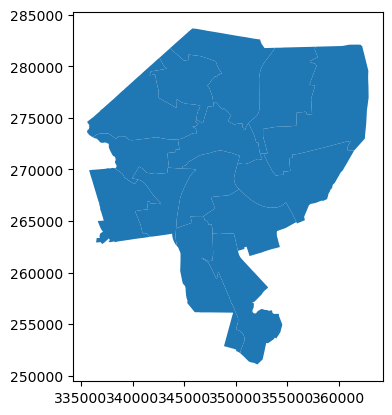

In [9]:
gdf.plot()

In [19]:
gdf.columns[0:15]

Index(['ID', 'DISTRICT', 'DISTRICTN', 'Shape_STAr', 'Shape_STLe', 'geometry',
       'Q1', 'Q2_18-24', 'Q2_25-29', 'Q2_30-39', 'Q2_40-49', 'Q2_50-64',
       'Q2_65 or older', 'Q3_Female', 'Q3_Male'],
      dtype='object')

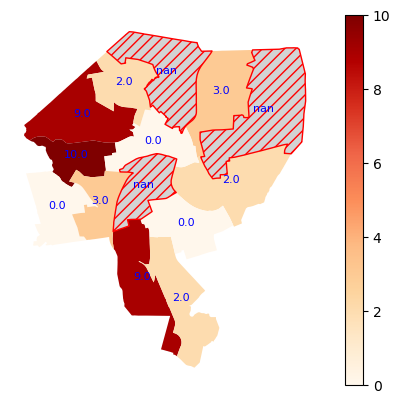

In [18]:
ax = gdf.plot(
    column='Q19_Definitely Not',
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values"
    }, cmap="OrRd")
ax.set_axis_off()

for idx, row in gdf.iterrows():
    plt.text(x=row.geometry.centroid.x,
             y=row.geometry.centroid.y, 
             s = str(row['Q19_Definitely Not']), 
             fontsize=8,
             color="blue" ,
             ha='center')

In [12]:
with open("../data/question_mapping.json", "r") as f:
    question_mapping = json.load(f)
question_mapping

{'UserLanguage': 'User Language',
 'Q1': 'Which ward is this survey from?',
 'Q2': 'What is your age group?',
 'Q3': 'What is your gender identity?',
 'Q4': 'What is your marital status?',
 'Q5': 'With what ethnicity or race(s) do you most identify? (Check all that apply)',
 'Q6': 'What is your religious affiliation? - Selected Choice',
 'Unnamed: 21': 'What is your religious affiliation? - Other - Text',
 'Q7': 'What is your highest level of education?',
 'Q8': 'What is your annual household income?',
 'Q9': 'How would you describe your political affiliation?',
 'Q10': 'Overall, do you feel that the country is heading in the right direction or the wrong direction?',
 'Q11': 'Overall, do you feel that Rhode Island is heading in the right direction or the wrong direction?',
 'Q12': 'Who did you vote for President',
 'Q13': 'Were you excited to vote for your presidential candidate?',
 'Q14': 'How confident are you that your Rhode Island politicians care about you?',
 'Q15': 'How confiden